# Madrid-Escuelas Aguirre `lm`

In [1]:
# Load packages
suppressMessages(library(lubridate))
suppressMessages(library(tidyverse))

suppressMessages(library(openair))
suppressMessages(library(BBmisc))
suppressMessages(library(caret))

#suppressMessages(library(downscaleR))
suppressMessages(library(gridExtra))

In [2]:
suppressMessages(library(doMC))
registerDoMC(cores=as.integer(detectCores()*0.75))

In [3]:
suppressMessages(library(repr))
options(repr.plot.width=30,
        repr.plot.height=15,
        #repr.plot.pointsize=50,
        repr.plot.family='serif'
        )

In [4]:
# Working directory
setwd("~/Repositories/AirQualityCOVID")

In [5]:
sites.lv <- c("es0118a")

save <- FALSE

## Load Data

In [6]:
load("data/data_AQ.rda")
load("data/meteorology.rda")

aq <- data_AQ %>%
        filter(site %in% sites.lv,
               date < ymd("2020-01-01")
              ) %>%
        timeAverage(avg.time = "day", type=c("site", "variable"))
aq$date <- as_date(aq$date)

mto <- data_Mto[data_Mto$site %in% sites.lv, ]

df <- merge(aq, mto,
              by = c("date", "site"), all.x=T) %>%
        drop_na() %>%
        select(-date_end, -process, -summary, -validity, -atmos_pres)

rm(data_AQ)
rm(data_Mto)

In [7]:
filter.IQR <- function(dat, n, qntl=0.75) {
    
    min.IQ <- quantile(dat$value, 1-qntl)
    max.IQ <- quantile(dat$value, qntl)
    
    interval.IQR <- max.IQ - min.IQ
    
    dat[which(dat$value > (min.IQ - (n*interval.IQR)) &
              dat$value < (max.IQ + (n*interval.IQR))),]
}

## Cross-Validation

In [8]:
leave.one.year.out <- function(yr, dat, omit.cl) { 
    # Do k-iteration of k-fold cv by pop yr data for test 
    #     and the rest for training
    # @params: omit.cl: columns to omit in the regression
    
    test <- which(year(dat$date) == yr)
    train <- which(year(dat$date) != yr)

    if(length(test) == 0) {
        return()
    } 
    if (length(train) == 0) {
        return()
    }
    
    model <- train(value ~., 
                   data=dat[train, -omit.cl],
                   method="lm",
                   preProcess="range"
                  )

    y.th <- predict(model, newdata=dat[test, -omit.cl])
    
    y.th.qq <- downscaleR:::eqm(dat[train,]$value, 
                                predict(model), 
                                y.th, 
                                n.quantile=99,
                                #method="eqm",
                                precip=FALSE, pr.threshold=0,
                                extrapolation="constant"
                               )
    
    data.frame(times.s = dat[test, ]$date,
               test.pred = y.th,
               test.pred.qq = y.th.qq,
               test.obs = dat[test,]$value
              )  
}

In [9]:
years <- 2013:2019

no.num.cl <- 1:3 # no numeric columns 
data.df <- data.frame()

# Create one model for each pair of station-pollutant
for (st in sites.lv) {
    data.st <- df[df$site == st,]
    
    for (pll in levels(as.factor(data.st$variable))) {
        dats <- data.st %>%
                filter(variable == pll) %>%
                #filter.IQR(3) %>%
                drop_na()
        
        model.df <- do.call(rbind, lapply(years, leave.one.year.out,
                                        dats, no.num.cl))

        data.df <- rbind(data.df,
                       cbind(data.frame("variable"=rep(pll, nrow(model.df)),
                                        "site"=rep(st, nrow(model.df)),
                             model.df))
                       )
    }
}
data.df$year <- as.factor(year(data.df$times.s))

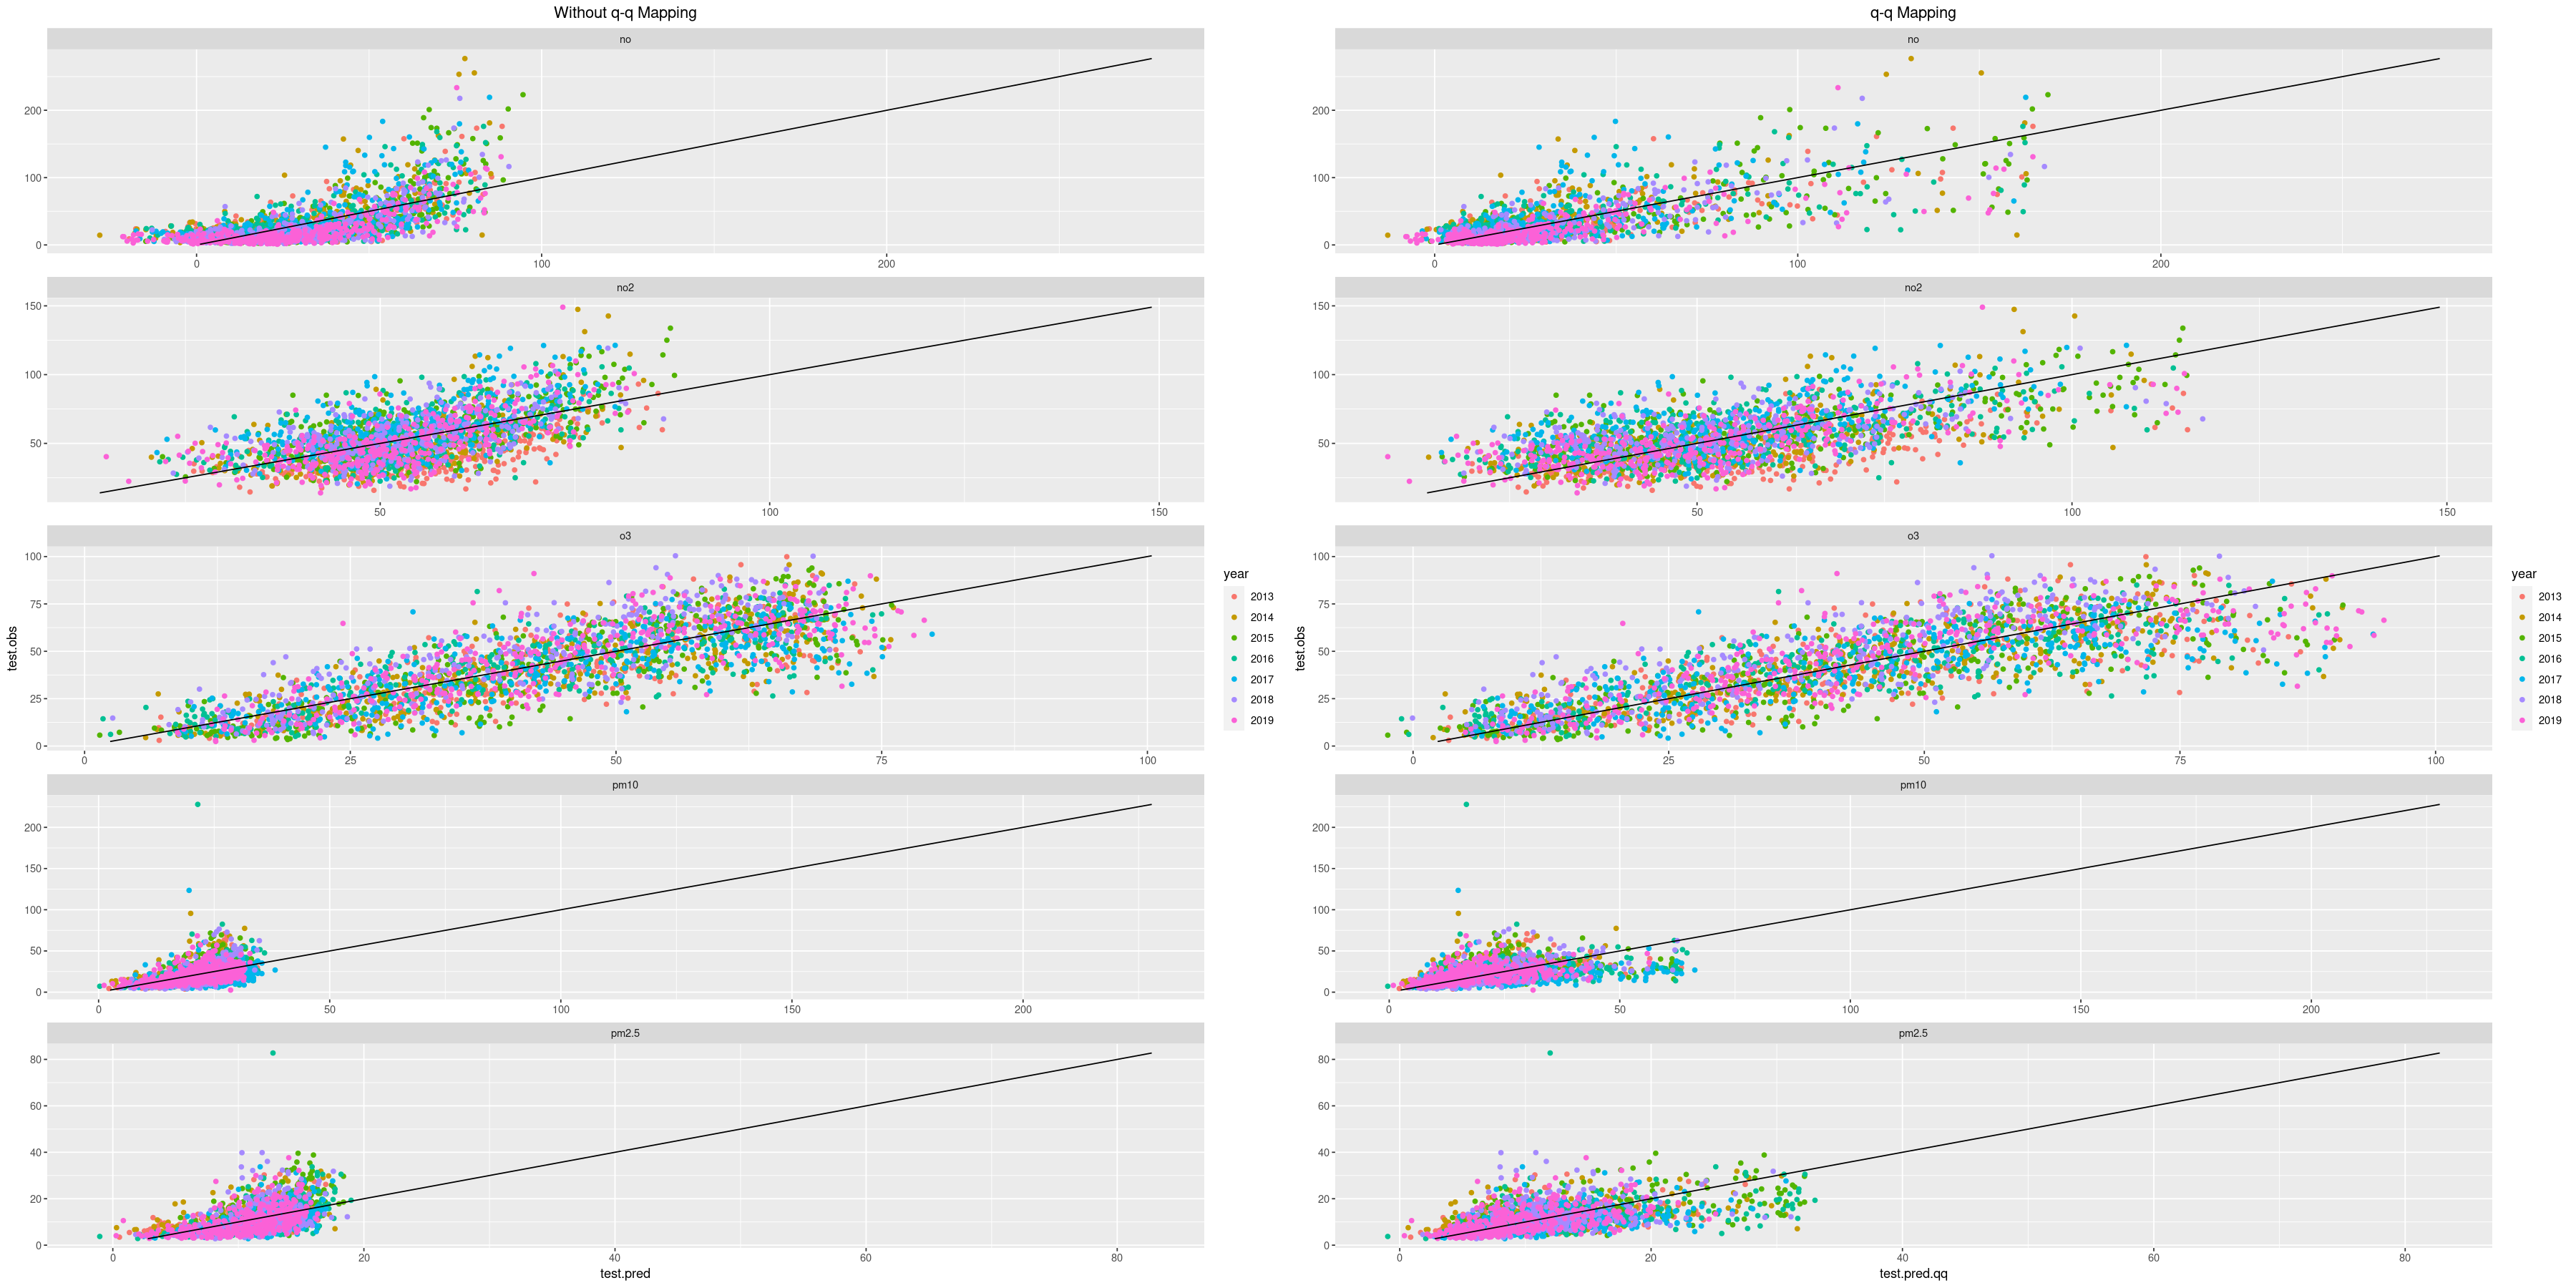

In [10]:
scatter <- ggplot(data=data.df) +
        geom_point(aes(x=test.pred, y=test.obs, color = year)) +
        geom_line(aes(x=test.obs, y=test.obs), color = "black") +
        ggtitle("Without q-q Mapping") +
        theme(plot.title = element_text(hjust = 0.5)) +
        facet_wrap(~variable, scale="free", ncol=1)

scatter.qq <- ggplot(data=data.df) +
        geom_point(aes(x=test.pred.qq, y=test.obs, color = year)) +
        geom_line(aes(x=test.obs, y=test.obs), color = "black") +
        ggtitle("q-q Mapping") +
        theme(plot.title = element_text(hjust = 0.5)) +
        facet_wrap(~variable, scale="free", ncol=1)

scatter.plt <- grid.arrange(scatter, scatter.qq, nrow=1)

In [11]:
if (save == TRUE) {
    ggsave(plot = scatter.plt, 
           filename = "lm-scatter-qq-mapping.png",
           device = "png", 
           path = "Plots/cross-validation/lm/",
           width = 20,
           height = 15,
          )
}

In [ ]:
timeSerie <- ggplot(data=data.df) +
                    geom_point(aes(x=times.s, y=test.pred, color = year)) +
                    geom_point(aes(x=times.s, y=test.obs), color = "black") +
                    ggtitle("Without q-q Mapping") +
                    theme(plot.title = element_text(hjust = 0.5)) +
                    facet_wrap(~variable, scale="free", ncol=1)

timeSerie.qq <- ggplot(data=data.df) +
                    geom_point(aes(x=times.s, y=test.pred.qq, color = year)) +
                    geom_point(aes(x=times.s, y=test.obs), color = "black") +
                    ggtitle("q-q Mapping") +
                    theme(plot.title = element_text(hjust = 0.5)) +
                    facet_wrap(~variable, scale="free", ncol=1)

timeSerie.plt <- grid.arrange(timeSerie, timeSerie.qq, nrow=1)

In [ ]:
if (save == TRUE) {
    ggsave(plot = timeSerie.plt, 
           filename = "timeSerie-qq-mapping.png",
           device = "png", 
           path = "Plots/cross-validation/lm/",
           width = 25,
           height = 15,
          )
}

In [ ]:
ggplot(data=data.df) +
    scale_color_manual(values=c("pred" = "red",
                                "obs" = "black",
                                "q-q Mapping" = "blue")) +
    geom_density(aes(x=test.pred, color="pred")) +
    geom_density(aes(x=test.pred.qq, color="q-q Mapping")) +
    geom_density(aes(x=test.obs, color="obs")) +
    facet_wrap(~variable, scale="free")

In [ ]:
if (save == TRUE) {
    ggsave(plot = last_plot(), 
           filename = "pdf-qq-mapping.png",
           device = "png", 
           path = "Plots/cross-validation/lm/",
           width = 10,
           height = 5,
          )
}